## Problem Set 2
Daniela Santos Cárdenas, Ana Brás Monteiro

In [1]:
# Importing the necessary libraries
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import pyblp
from linearmodels.iv import IV2SLS
from statsmodels.sandbox.regression.gmm import GMM
from statsmodels.sandbox.regression import gmm
from linearmodels.iv import IVGMM
from scipy.linalg import block_diag
import matplotlib.pyplot as plt

pyblp.options.digits = 2
pyblp.options.verbose = False

In [2]:
# Import data 

colnames=['mkt_id', 'prod_id', 'prod_share', 'prod_att1', 'prod_att2', 'prod_att3', 'price', 'shifter1', 'shifter2', 'shifter3', 'group'] 

df = pd.read_csv('../data/Data.csv', names=colnames, header=None)

In [32]:
df.describe()

,mkt_id,prod_id,prod_share,prod_att1,prod_att2,prod_att3,price,shifter1,shifter2,shifter3,group
count,970.000000,970.000000,9.700000e+02,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000
mean,26.167010,10.430928,1.912517e-02,-0.030330,-0.004903,-0.057823,5.577779,-0.029543,-0.012141,-0.044407,2.010309
std,14.485213,5.990177,6.025534e-02,0.995995,0.999779,1.016903,1.371331,1.007472,0.989332,0.977154,0.818956
min,1.000000,1.000000,3.019000e-07,-2.985200,-3.104500,-4.167300,1.328500,-2.850200,-4.096800,-3.251200,1.000000
25%,14.000000,5.000000,9.976725e-05,-0.706257,-0.682220,-0.706403,4.708150,-0.710245,-0.704515,-0.700940,1.000000
50%,26.500000,10.000000,7.848100e-04,-0.064417,0.042951,-0.068317,5.527950,-0.055330,0.017694,-0.001928,2.000000
75%,39.000000,15.000000,5.950150e-03,0.670627,0.681762,0.620657,6.507125,0.688550,0.695118,0.590225,3.000000
max,50.000000,25.000000,5.582900e-01,2.811000,3.690400,3.231500,10.000000,3.275500,3.681100,3.272600,3.000000


## 2.1 Logit Demand

**Question a)**

Estimate an aggregate Logit model using OLS based on the following utility function that individual i derives from buying product j in market n: 

$$u_{ijn} = \alpha p_{jn} + x_{jn} \beta + \xi_{jn} + \varepsilon_{ijn}$$

Dependent variable: $\delta_{jn} = log(\frac{s_{jn}}{s_{0n}})$

In [3]:
# Creating market shares 
df['mkt_share'] = df.groupby('mkt_id')['prod_share'].transform('sum')

# Share of the outside good 
df['mkt_share_out'] = 1 - df['mkt_share']

# Calculate log of ratio 
df['utility'] = np.log(df['prod_share']/df['mkt_share_out'])


In [10]:
# OLS
ols_logit = smf.ols('utility ~ 1 + price + prod_att1 + prod_att2 + prod_att3', data=df).fit()
ols_logit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                utility   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     1294.
Date:                Tue, 10 Jan 2023   Prob (F-statistic):               0.00
Time:                        19:11:00   Log-Likelihood:                -1491.9
No. Observations:                 970   AIC:                             2994.
Df Residuals:                     965   BIC:                             3018.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9496      0.163      5.818      0.000       0.629       1.270
price         -1.3385      0.028    -47.054      0.000      -1.394      -1.283
prod_att1      2.4160      0.045     53.906      0.000       2.328       2.504
prod_att2      0.5124      0.045     11.319      0.000       0.424       0.601
prod_att3      0.3696      0.043      8.689      0.000       0.286       0.453
==============================================================================
Omnibus:                        2.031   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.362   Jarque-Bera (JB):                2.082
Skew:                           0.088   Prob(JB):                        0.353
Kurtosis:                       2.857   Cond. No.                         26.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Question b)**

Estimate the same Logit model using Instrumental Variables (IV). Use the cost shifters as instruments, providing the results also for the 1st stage. How do your results change compared to the OLS case? Provide an intuition for the endogeneity bias. Calculate the mean across markets of own and cross price elasticities.

In [11]:
# Show first stage
ols_fs = smf.ols('price ~ 1 + prod_att1 + prod_att2 + prod_att3 +shifter1 + shifter2 + shifter3', data=df).fit()
print(ols_fs.summary()) 

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     173.0
Date:                Tue, 10 Jan 2023   Prob (F-statistic):          3.50e-149
Time:                        19:18:40   Log-Likelihood:                -1327.4
No. Observations:                 970   AIC:                             2669.
Df Residuals:                     963   BIC:                             2703.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.6208      0.031    183.015      0.0

In [12]:
iv_logit = IV2SLS.from_formula('utility ~ 1 + [price ~ shifter1 + shifter2 + shifter3] + prod_att1 + prod_att2 + prod_att3', data = df).fit()
iv_logit.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                utility   R-squared:                      0.8400
Estimator:                    IV-2SLS   Adj. R-squared:                 0.8393
No. Observations:                 970   F-statistic:                    3905.7
Date:                Tue, Jan 10 2023   P-value (F-stat)                0.0000
Time:                        19:18:45   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      1.6129     0.2304     7.0003     0.0000      1.1613      2.0644
prod_att1      2.4668     0.0478     51.598     0.0000      2.3731      2.5605
prod_att2      0.5616     0.0491     11.435     0.0000      0.4653      0.6579
prod_att3      0.3725     0.0444     8.3935     0.0000      0.2855      0.4595
price         -1.4571     0.0417    -34.962     0.0000     -1.5388     -1.3754
==============================================================================

Endogenous: price
Instruments: shifter1, shifter2, shifter3
Robust Covariance (Heteroskedastic)
Debiased: False
"""

Since we expect the coefficients to be biased towards zero, using an instrument for price makes the coefficient be more negative.

**Elasticities** 

Own-price elasticities: $\epsilon_{jj} = \alpha p_{jn} (1-s_{jn})$

Cross-price elasticities: $\epsilon_{jk} = - \alpha p_{kn} s_{kn}$

In [13]:
# Own price elasticities 
df['e_jj'] = iv_logit.params['price'] * df['price'] * (1 - df['prod_share'])
# Mean across markets 
np.mean(df.e_jj)

-7.993652493251072

In [14]:
# Cross-price elasticities of any good j wrt k.
df['e_jk'] = - iv_logit.params['price'] * df['price'] * df['prod_share']
# Mean across markets
np.mean(df.e_jk) 

# I tried weighting the means by market share but it doesn't change much. Not sure what's ideal. 

0.13366860095027766

**Question c)**

You will need to construct a GMM objective function with both demand and supply moments, with the price coefficient α entering in both moments (cross-equation restriction). How do your results change compared to the case with just IV?


In [ ]:
## Resources that I used to learn about this: 
# Carole's help 
# Info on classes and OOP: https://realpython.com/python3-object-oriented-programming/
# GMM estimator: https://www.statsmodels.org/stable/generated/statsmodels.sandbox.regression.gmm.GMM.html#statsmodels.sandbox.regression.gmm.GMM

In [17]:
# Define exog, endog and instruments 

instrument_df = df[["shifter1", "shifter2","shifter3"]]  # instruments
exog_df = df[["price", "prod_share", "prod_att1", "prod_att2","prod_att3"]]  # explanatory variables 
endog_df = df[["utility", "price"]] # dependent variable
endog, exog, instrument  = map(np.asarray, [endog_df, exog_df, instrument_df]) # Creates matrices


class GMMdemand(GMM): 
    
    def momcond(self, params): # This is where we define moment conditions 
        alpha, beta1, beta2, beta3, gamma1, gamma2, gamma3, k1, k2 = params # define params  

        beta = np.array([beta1,beta2,beta3])
        gamma = np.array([gamma1,gamma2,gamma3])

        x = self.exog # endog, exog, instrument are inputs in the parent class 
        z = self.instrument
        y = self.endog 

        n_obs = z.shape[0] # Number of observations
        price = x[:, 0] # Price
        share = x[:, 1] # Market share
        exogenous_x = x[:, 2:] # Product characteristics 
        log_share = y[:, 0] # Log market share

        # Moment conditions 
        m1 = np.array(log_share - k1 * np.ones(n_obs) - alpha * price - beta.dot(exogenous_x.T)).reshape(1,n_obs) # Demand side 
        m2 = np.array(price - k2 * np.ones(n_obs) - gamma.dot(z.T) + 1/(alpha*(1-share))).reshape(1,n_obs)  # Supply side 
        m1_all = np.concatenate((m1, m1,m1, m1, m1, m1, m1), axis = 0) 
        m2_all = np.concatenate((m2, m2,m2, m2), axis = 0)

        # Instrument matrix
        instruments_m1 = np.concatenate((np.ones(n_obs).reshape(1, n_obs), exogenous_x.T, z.T), axis = 0) 
        instruments_m2 = np.concatenate((np.ones(n_obs).reshape(1, n_obs), z.T), axis = 0) 
        instruments =  block_diag(instruments_m1, instruments_m2).T
        
        errors = block_diag(m1_all, m2_all).T # had to transpose to get the right dimensions 
        moments = instruments*errors # Creating here our Z'e 

        return moments


model1 = GMMdemand(endog, exog, instrument, k_moms = 11, k_params=9) # Minimization 

guess = np.array([-1.5, 1, 1, 1, 1, 1, 1, 1, 1]) # Initial guess

results_GMM = model1.fit(guess, maxiter=100, optim_method='bfgs', wargs=dict(centered=False)) 
xnames = ["alpha", "beta1", "beta2", "beta3", "gamma1", "gamma2", "gamma3", "k1", "k2"]
print(results_GMM.summary(xname = xnames))


Optimization terminated successfully.
         Current function value: 0.000107
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 0.000703
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.000703
         Iterations: 3
         Function evaluations: 6
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.000703
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
                              GMMdemand Results                               
Dep. Variable:           ['y1', 'y2']   Hansen J:                        1.363
Model:                      GMMdemand   Prob (Hansen J):                 0.506
Method:                           GMM                                         
Da

In [18]:
results_GMM.params

array([-1.45474915,  2.46120289,  0.55666892,  0.37522779,  0.48669492,
        0.51544953,  0.45833685,  1.59944986,  4.91398468])

Results don't look so different from what we got from IV, suggesting that the supply side doesn't seem to impact much the results. 

### Simulate a merger

For the merged firms (k,j) the supply side equation will be: 

$$p_k=mc_k - \frac{1}{\alpha(1-s_k-s_j)}$$

For the firms that don't merge, the supply side equation will be: 

$$p_f=mc_f - \frac{1}{\alpha(1-s_f)}$$

For all firms the demand side equation will be: 

$$s_j= \frac{e^{k_1+\alpha p_j+ x_j \beta} }{1+ \sum_{k=1}^{J}e^{k_1+\alpha p_k+ x_k \beta} }$$

In [19]:
# Identify two largest firms in each market

df_grouped = df.groupby('mkt_id')
df['first_ms'] = df_grouped.transform(lambda x: x.nlargest(1).min())['prod_share'] # find largest
df['second_ms'] = df_grouped.transform(lambda x: x.nlargest(2).min())['prod_share']  # find second largest
# dummies = 1 if the firm is one of the merged firms, also dummies for biggest and second biggest firm

df['merged_firm'] = np.where((df['prod_share']== df['first_ms']) | (df['prod_share'] == df['second_ms']), 1, 0)


df['first_firm'] = np.where((df['prod_share']== df['first_ms']), 1, 0)
df['second_firm'] = np.where((df['prod_share'] == df['second_ms']), 1, 0)

In [20]:
# Naming the results of GMM

alpha = results_GMM.params[0]
beta1= results_GMM.params[1]
beta2 = results_GMM.params[2]
beta3 = results_GMM.params[3]
gamma = results_GMM.params[4:7]
k1 = results_GMM.params[7]
k2 = results_GMM.params[8]

In [21]:
## Compute mc pre merge

mc= df['price'] + 1/(alpha*(1-df['prod_share'])) # marginal cost

In [22]:
price_iter = df.price
difference = 1
convergence = 1

In [23]:
# Solve for markets shares and prices to equate supply side and demand side

while convergence >= 1e-10 :


    differencepre = difference

    price_d = price_iter

    # STEP 1: Use demand side eq. to get market shares using observed prices

    df['EXP'] = np.exp(k1 + alpha * price_d + beta1 * df['prod_att1'] + beta2 * df['prod_att2'] + beta3 *df['prod_att3'])
    df['sumEXP_'] = df.groupby('mkt_id').transform('sum')['EXP']
    df['ms_d'] = df['EXP'] / (1 + df['sumEXP_']) # market share using demand equation logit

    # STEP 2: Calculate new denominator for supply equation using new shares and parameters

    ## first need to compute market shares of merged firms

    df['first_ms2'] = np.where((df['first_firm']== 1), df['ms_d'], 0) # MS of largest firm
    df['second_ms2'] = np.where((df['second_firm']== 1), df['ms_d'], 0) # MS of second largest firm

    df_grouped = df.groupby('mkt_id')

    df['first_ms'] = df_grouped.transform('sum')['first_ms2'] # column for ms of largest firm in each market
    df['second_ms'] = df_grouped.transform('sum')['second_ms2']

    ## denominator of price equation --> 1-si for unmerged firms and 1-si-sj for merged firms

    denominator = 1 - df['ms_d'] - df['first_firm']*df['second_ms'] - df['second_firm']*df['first_ms']

    # STEP 3: update prices

    price_iter = mc - (alpha*(denominator))**(-1)


    # Difference between demand and supply prices (euclidean distance), this is what we're minimizing

    difference = (price_d - price_iter).T.dot((price_d - price_iter))

    # difference between the difference in the last step and the difference in this step

    convergence = abs(differencepre - difference)
    
df['price_iter']=price_iter

convergence

9.061285055622648e-11

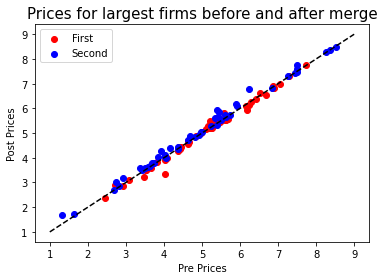

In [24]:
# Compare pre and post merger

largest = df.loc[(df.first_firm == 1)]
largest2 = df.loc[(df.second_firm == 1)]

fig,ax = plt.subplots()
plt.scatter(largest['price'], largest['price_iter'], c='red',label='First' )
plt.scatter(largest2['price'], largest2['price_iter'], c='blue',label='Second' )
plt.plot( [1,9], [1,9], linestyle='--', color='k' )
plt.xlabel('Pre Prices') 
plt.ylabel('Post Prices') 
plt.legend()
plt.title(label="Prices for largest firms before and after merge",
          fontsize=15,
          color="black")
plt.show()

Prices of the firms that merged increased, but not a lot. For the largest firms, prices dropped in some cases.

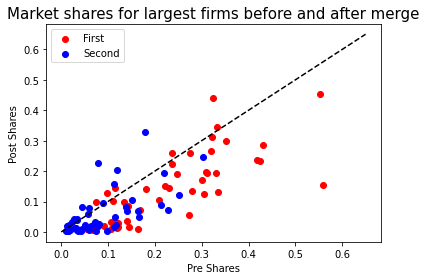

In [25]:
fig,ax = plt.subplots()

plt.scatter(largest['prod_share'], largest['ms_d'], c='red',label='First' )
plt.scatter(largest2['prod_share'], largest2['ms_d'], c='blue',label='Second' )
plt.plot( [0,0.65], [0,0.65], linestyle='--', color='k' )
plt.xlabel('Pre Shares') 
plt.ylabel('Post Shares') 
plt.legend()
plt.title(label="Market shares for largest firms before and after merge",
          fontsize=15,
          color="black")
plt.legend()

plt.show()

In [25]:
df['diff']=(largest['ms_d']-largest['prod_share'])*100/largest['prod_share']
df['diff'].describe()

count    50.000000
mean    -42.892569
std      35.606415
min     -94.658612
25%     -73.725662
50%     -43.531750
75%     -18.540519
max      35.718083
Name: diff, dtype: float64

Market shares decreased after the merge, specially for the largest firms in the different market. The median was a 43% decrease in market share.

## 2.2 Nested Logit Demand

**Question a)**

Estimate a Nested Logit Model using IV based on the following: 

$$u_{ijn} = \alpha p_{jn} + x_{jn} \beta + \xi_{jn} + \zeta_{ign} + (1-\sigma)\varepsilon_{ijn}$$

We'll estimate: 

$$log(\frac{s_{jn}}{s_{0n}}) = \alpha p_{jn} + x_{jn} \beta + \sigma log(\frac{s_{jn}}{s_{gn}}) + \xi_{jn}$$

Got help from https://pyblp.readthedocs.io/en/stable/_notebooks/tutorial/logit_nested.html

In [26]:
# Creating group shares 
df['group_share'] = df.groupby(['group', 'mkt_id'])['prod_share'].transform('sum')

# Creating ratio of product share to group share 
df['sjn_sgn'] = np.log(df['prod_share']/df['group_share'])


In [27]:
nest_logit = IVGMM.from_formula('utility ~ 1 + [price + sjn_sgn ~ shifter1 + shifter2 + shifter3] + prod_att1 + prod_att2 + prod_att3', data=df)

res_nest_logit = nest_logit.fit()

res_nest_logit.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:                utility   R-squared:                      0.8998
Estimator:                     IV-GMM   Adj. R-squared:                 0.8993
No. Observations:                 970   F-statistic:                    6272.3
Date:                Thu, Jan 12 2023   P-value (F-stat)                0.0000
Time:                        20:30:47   Distribution:                  chi2(5)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.3822     0.9661     0.3956     0.6924     -1.5112      2.2757
prod_att1      2.2253     0.1872     11.890     0.0000      1.8584      2.5921
prod_att2      0.3788     0.1441     2.6286     0.0086      0.0964      0.6612
prod_att3      0.2909     0.0744     3.9078     0.0001      0.1450      0.4369
price         -1.0505     0.3159    -3.3254     0.0009     -1.6696     -0.4313
sjn_sgn        0.2923     0.2268     1.2887     0.1975     -0.1522      0.7368
==============================================================================

Endogenous: price, sjn_sgn
Instruments: shifter1, shifter2, shifter3
GMM Covariance
Debiased: False
Robust (Heteroskedastic)
"""

The price coefficient is lower than in the logit model which makes sense because now the log of share relative to the group takes some explanatory power. Sigma is 0.3 which means that the correlation of the within-group preference is not very strong.

**Own-price elasticities** 

Products in a nest: $\epsilon_{jj} = \frac{\alpha p_{jn}}{1-\sigma} (1-\sigma s_{j|g,n} - (1-\sigma)s_{jn})$


In [29]:

results = pd.read_html(res_nest_logit.summary.tables[1].as_html(),header=0,index_col=0)[0]

alpha = results['Parameter'].values[4]
sigma = results['Parameter'].values[5]

In [30]:
# All the products are in a nest 
df['e_jj_nest'] = (alpha * df['price'])/(1 - sigma) * (1 - sigma * (df['prod_share']/df['group_share']) - (1 - sigma) * df['prod_share'])
np.mean(df.e_jj_nest)

-7.876126607393617

**Cross-price elasticities** 

Products in different nests: $\epsilon_{jk} = - \alpha p_{kn} s_{kn}$

Products in the same nest: $\epsilon{jk} = - \frac{\alpha p_{kn}}{1 - \sigma}(\sigma s_{k|g,n} + (1 - \sigma)s_{kn})$

Average cross-price elasticity:

$$ \bar{\varepsilon_{jk}}= \frac{\sum_g \left( \sum_{jg} \varepsilon_{jg,kg}\times (N_g-1) + \sum_{g'\neq g} \sum_{jg} \varepsilon_{jg,kg'} \ast (N-N_g)\right)}{N(N-1)} $$

Mean within group elasticities:

$$ \bar{\varepsilon_{within}}= \frac{\sum_m  \sum_g \left( \sum_{j} \varepsilon_{jgm,kgm}\times (N_{mg}-1) \right)}{\sum_m \sum_g (N_{gm}-1)} $$
where $N_{mg}$ is the number of $g$-group products in market $m$.

Mean across group elasticities

$$ \bar{\varepsilon_{across}}= \frac{\sum_m  \sum_{g' \neq g} \left( \sum_{j} \varepsilon_{jgm,kg'm}\times (N_m-N_{mg}) \right)}{\sum_m \sum_{g' \neq g} N_m-N_{mg}} $$

In [87]:
# Products in different nests 
df['diff'] = - alpha * df['price'] * df['prod_share']

df['same'] = - (alpha * df['price'])/(1 - sigma) * ( sigma * (df['prod_share']/df['group_share']) + (1 - sigma) * df['prod_share'])
 

N = sum(df.groupby(['prod_id', 'mkt_id']).transform('count')['group'])
df['Ng'] = df.groupby(['group']).transform('count')['prod_share']
df['Nm'] = df.groupby(['mkt_id']).transform('count')['group']
df['Nmg'] = df.groupby(['group', 'mkt_id']).transform('count')['prod_share']


In [88]:
#Average cross-price elasticity
(sum(df['same'] * (df['Ng']-1) + df['diff'] * (N - df['Ng'])) ) / (N * (N-1))


0.19868297659816603

In [93]:
print(df[['mkt_id', 'prod_id', 'group', 'same','Nm', 'Ng', 'Nmg']].head(10))

   mkt_id  prod_id  group      same  Nm   Ng  Nmg
0       1        1      3  0.003016  20  330   10
1       1        2      2  0.017505  20  320    5
2       1        3      2  0.068193  20  320    5
3       1        4      1  1.948488  20  320    5
4       1        5      3  0.006906  20  330   10
5       1        6      2  1.640932  20  320    5
6       1        7      1  0.006124  20  320    5
7       1        8      3  0.013805  20  330   10
8       1        9      2  0.011525  20  320    5
9       1       10      1  0.049344  20  320    5


In [90]:
# mean within group elasticities

sum(df['same'] * (df['Nmg']-1)) / sum(df['Nmg'] - 1)

0.35357156135623197

In [94]:
# mean across group elasticities

(sum(df['diff'] * (df['Nm'] - df['Nmg']))) / (sum(df['Nm'] - df['Nmg']))

0.09588551763000888

The average within group elasticity is much larger than the cross-group elasticities, which makes sense given the assumption of the structure of cross-elasticities in the nested logit model.


## 2.3 Random Coefficient Logit

In [53]:
colnames=['market_ids', 'product_ids', 'shares', 'prod_att1', 'prod_att2', 'prod_att3', 'prices', 'demand_instruments0', 'demand_instruments1', 'demand_instruments2', 'group'] 
product_data = pd.read_csv('../data/Data.csv', names=colnames, header=None)

In [54]:
product_data['supply_instruments3'] = np.square(df['prod_att1'])
product_data['supply_instruments4'] = np.square(df['prod_att2'])
product_data['supply_instruments5'] = np.square(df['prod_att3'])
product_data['demand_instruments3'] = np.square(df['demand_instruments0'])
product_data['demand_instruments4'] = np.square(df['demand_instruments1'])
product_data['demand_instruments5'] = np.square(df['demand_instruments2'])

In [55]:
X1_formulation = pyblp.Formulation('1 + prices + prod_att1 + prod_att2 + prod_att3')
X2_formulation = pyblp.Formulation('0 + prices + prod_att1 + prod_att2 + prod_att3')
product_formulations = (X1_formulation, X2_formulation)
product_formulations

(1 + prices + prod_att1 + prod_att2 + prod_att3,
 prices + prod_att1 + prod_att2 + prod_att3)

In [56]:
mc_integration = pyblp.Integration('monte_carlo', size=50, specification_options={'seed': 0})
mc_integration

Configured to construct nodes and weights with Monte Carlo simulation with options {seed: 0}.

In [57]:
mc_problem = pyblp.Problem(product_formulations, product_data, integration=mc_integration)
mc_problem

Dimensions:
 T    N    I     K1    K2    MD 
---  ---  ----  ----  ----  ----
50   970  2500   5     4     10 

Formulations:
       Column Indices:           0         1          2          3          4    
-----------------------------  ------  ---------  ---------  ---------  ---------
 X1: Linear Characteristics      1      prices    prod_att1  prod_att2  prod_att3
X2: Nonlinear Characteristics  prices  prod_att1  prod_att2  prod_att3           

In [58]:
bfgs = pyblp.Optimization('bfgs', {'gtol': 1e-4})
bfgs

Configured to optimize using the BFGS algorithm implemented in SciPy with analytic gradients and options {gtol: +1.0E-04}.

In [59]:
# Results with restricted diagonal matrix for random tastes using Monte Carlo Integration.

results1 = mc_problem.solve(sigma=np.eye(4), optimization=bfgs)
results1

Problem Results Summary:
GMM   Objective  Gradient      Hessian         Hessian     Clipped  Weighting Matrix  Covariance Matrix
Step    Value      Norm    Min Eigenvalue  Max Eigenvalue  Shares   Condition Number  Condition Number 
----  ---------  --------  --------------  --------------  -------  ----------------  -----------------
 2    +6.4E-01   +5.2E-05     +3.3E+00        +6.7E+01        0         +8.3E+01          +4.1E+04     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:00:12       Yes          29           38          13624        42681   

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
 Sigma:      prices    prod_att1   prod_att2   prod_att3 
---------  ----------  ----------  ----------  ----------
 prices     -1.6E-01                                 

In [71]:
elasticities = results1.compute_elasticities()

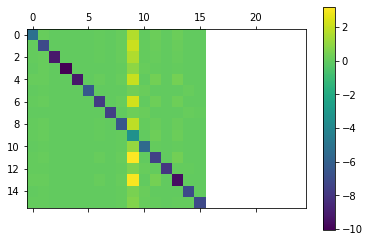

In [72]:
#Example of the elasticity matrix for market 4

single_market = product_data['market_ids'] == 4
plt.colorbar(plt.matshow(elasticities[single_market]));

The diagonal of the first image consists of own elasticities and the diagonal of the second image consists of diversion ratios to the outside good. 

In [62]:
means = results1.extract_diagonal_means(elasticities)

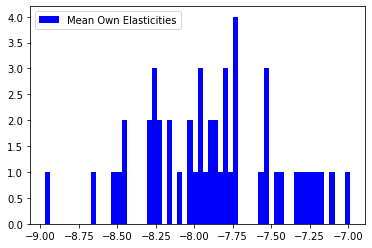

In [63]:
plt.hist(
    [means.flatten()],
    color=['blue'],
    bins=60
);
plt.legend(['Mean Own Elasticities']);

In [64]:
# Results using unrestricted covariance matrix for random tastes using Monte Carlo integration.
results2 = mc_problem.solve(sigma=np.ones((4, 4)), optimization=bfgs)
results2

Problem Results Summary:
GMM   Objective  Gradient      Hessian         Hessian     Clipped  Weighting Matrix  Covariance Matrix
Step    Value      Norm    Min Eigenvalue  Max Eigenvalue  Shares   Condition Number  Condition Number 
----  ---------  --------  --------------  --------------  -------  ----------------  -----------------
 2    +1.2E-12   +7.3E-06     -1.4E-04        +4.7E+01        0         +9.8E+01          +1.3E+18     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:00:20       Yes          26           35          17925        55531   

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
 Sigma:      prices    prod_att1   prod_att2   prod_att3   |  Sigma Squared:    prices    prod_att1   prod_att2   prod_att3 
---------  ----------  ----------  ---------

In [65]:
elasticities = results2.compute_elasticities()

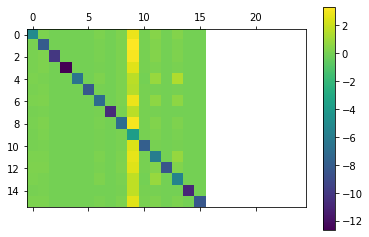

In [66]:
#Example of the elasticity matrix for market 4

single_market = product_data['market_ids'] == 4
plt.colorbar(plt.matshow(elasticities[single_market]));

In [67]:
means = results2.extract_diagonal_means(elasticities)

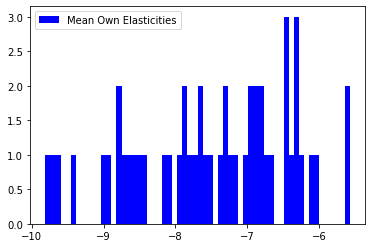

In [68]:
plt.hist(
    [means.flatten()],
    color=['blue'],
    bins=60
);
plt.legend(['Mean Own Elasticities']);